<a href="https://colab.research.google.com/github/SNWambui/APIs/blob/master/notebooks/Cervical_Spine_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Necessary Libraries And Modules

These are the libraries we will need for EDA, preprocessing image data, splitting the data, computing accuracy and improving model performance

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

# from sklearn import decomposition 
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.svm import LinearSVC 
# from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, ParameterGrid

### Mount Files from Google Drive to Read Image and Variable data for analysis

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# set the theme for EDA
sns.set_theme(palette='muted')

## EDA on Metadata For Test Set

The image data is stored in 2019 image directories where each directory contains a certain number of images from a given scan. For each of these directories, the train.csv is a file with metadata that describes whether all the images in that directory correspond to having a fracture based the scans of the cervical spine.

Specifically, for given row, we have the variables show in the table below and each of the variables is explained in the github repository under project_codebook. An example is: if row 1 has C1 =1 and C2 - C7 = 0, then there is a fracture in one vertebrae and therefore overall fracture for the patient. This applies to all the images in that directory in row 1

In [4]:
metadat = pd.read_csv('/content/gdrive/MyDrive/Tutorial_Session/train.csv')
metadat.head()

slice_path  \
0  ../input/rsna-2022-cervical-spine-fracture-det...   
1  ../input/rsna-2022-cervical-spine-fracture-det...   
2  ../input/rsna-2022-cervical-spine-fracture-det...   
3  ../input/rsna-2022-cervical-spine-fracture-det...   
4  ../input/rsna-2022-cervical-spine-fracture-det...   

            StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7  \
0  1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0   
1  1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0   
2  1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0   
3  1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0   
4  1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0   

   slice_id  width  height  
0        12    512     512  
1       210    512     512  
2       120    512     512  
3       208    512     512  
4       141    512     512

In [5]:
# get summary statistics for all the columns
metadat.describe(include='all')

slice_path  \
count                                              711601   
unique                                             711601   
top     ../input/rsna-2022-cervical-spine-fracture-det...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                 StudyInstanceUID  patient_overall             C1  \
count                      711601    711601.000000  711601.000000   
unique                       2019              NaN            NaN   
top     1.2.826.0.1.3680043.20756              NaN            NaN   
freq                         1082              NaN            NaN   
mean                          NaN         0.450982       0.067459   
std                           NaN         0.497592       0.250816   
min                           NaN         0.000000       0.000000   
25%                           NaN         0.000000       0.000000   
50%                           NaN         0.000000       0.000000   
75%                           NaN         1.000000       0.000000   
max                           NaN         1.000000       1.000000   

                   C2             C3             C4             C5  \
count   711601.000000  711601.000000  711601.000000  711601.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         0.127209       0.035374       0.051190       0.079213   
std          0.333207       0.184723       0.220386       0.270071   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.000000       0.000000       0.000000       0.000000   
max          1.000000       1.000000       1.000000       1.000000   

                   C6             C7       slice_id          width  \
count   711601.000000  711601.000000  711601.000000  711601.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         0.132415       0.185012     201.459901     512.283736   
std          0.338942       0.388308     143.653159       8.482687   
min          0.000000       0.000000       1.000000     512.000000   
25%          0.000000       0.000000      89.000000     512.000000   
50%          0.000000       0.000000     177.000000     512.000000   
75%          0.000000       0.000000     281.000000     512.000000   
max          1.000000       1.000000    1082.000000     768.000000   

               height  
count   711601.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean       512.281326  
std          8.481772  
min        512.000000  
25%        512.000000  
50%        512.000000  
75%        512.000000  
max        768.000000

In [6]:
# drop columns we don't need
columns = ["slice_path", "width", "height", "slice_path"]
metadat = metadat.drop(columns, axis=1)
metadat.head()

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7  \
0  1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0   
1  1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0   
2  1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0   
3  1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0   
4  1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0   

   slice_id  
0        12  
1       210  
2       120  
3       208  
4       141

In [7]:
# check for null values
metadat.isnull().sum()

StudyInstanceUID    0
patient_overall     0
C1                  0
C2                  0
C3                  0
C4                  0
C5                  0
C6                  0
C7                  0
slice_id            0
dtype: int64

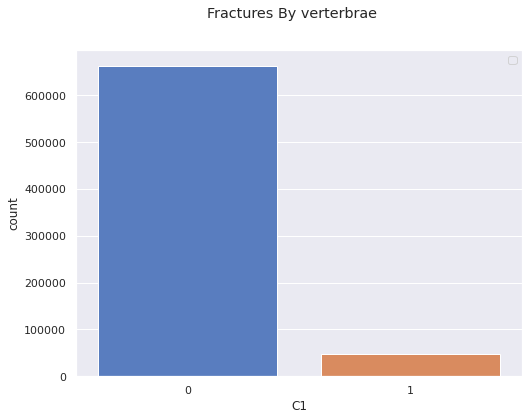

In [8]:
# data distrubution by classes
fig, ax = plt.subplots(figsize=(8,6))

sns.countplot(x="C1", data=metadat, 
            ax=ax)
# sns.catplot(data=metadat, x="C1", kind="box")

ax.set_xlabel("C1")
ax.legend()

fig.suptitle("Fractures By verterbrae");

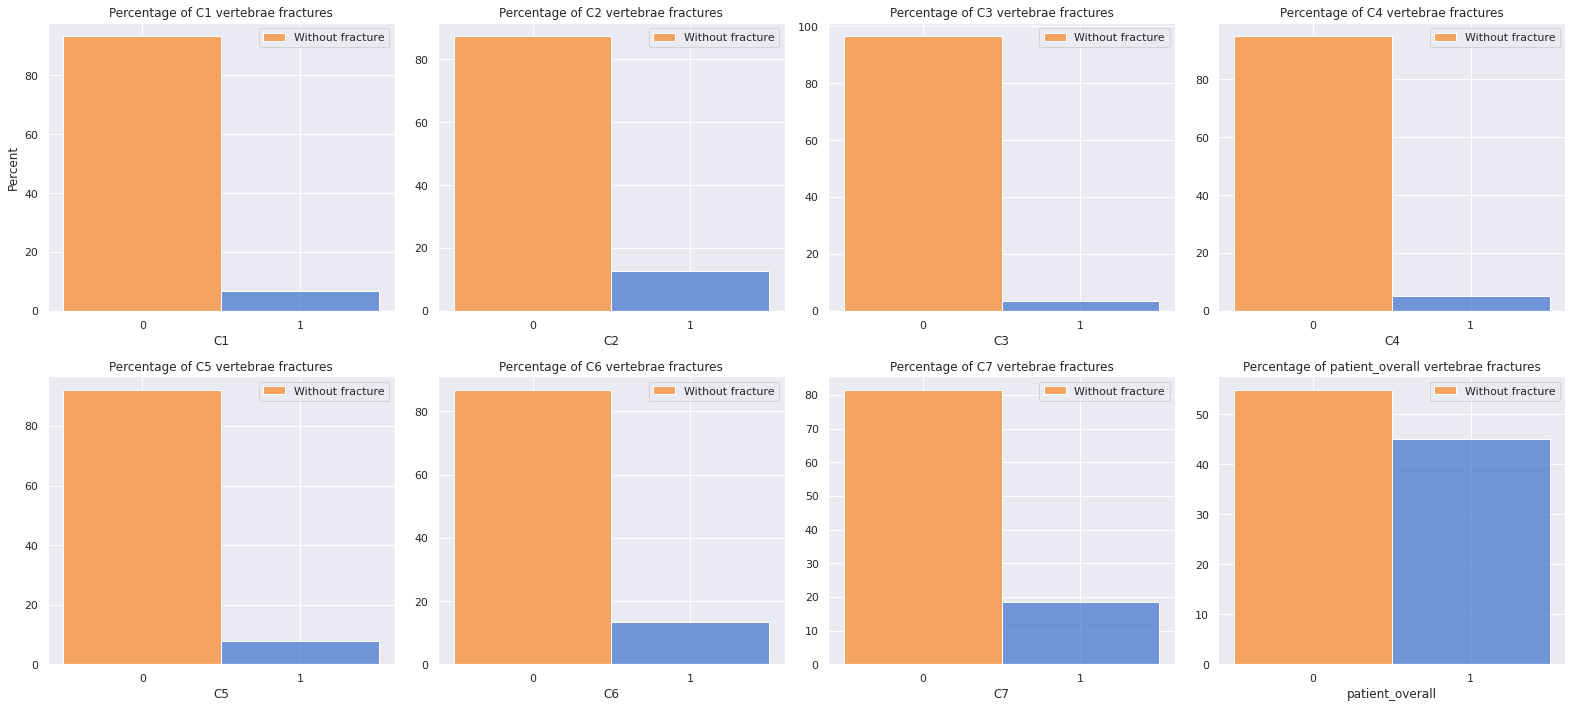

In [30]:
columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'patient_overall']
fig, axs = plt.subplots(2, 4, figsize=(22, 10))
#flatteen the axis
axs = axs.flatten()

for ax, column in zip(axs, columns):
    sns.histplot(metadat[column], discrete=True, ax=ax, stat='percent')
    ax.xaxis.set_major_locator(MultipleLocator(1))  # set ticks at each position
    ax.set_title(f"Percentage of {column} vertebrae fractures")
    ax.patches[0].set_facecolor('sandybrown')
    # ax.patches[1].set_facecolor('teal')
    ax.legend(["Without fracture", "With Fracture"])
    if ax != axs[0]:
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

From the visualizations above, we can see that C1, C3, C4, C5 vertebrae have the lowest proportion of of fractures. On the other hand, we can see that C2, C6, and C7 have comparatively higher proportion of fractures. C7 has the highest proportion of fractures compared to other vertebrae because its the vertebrae that connects the neck with the upper-back and is highly associated with back injuries. Back injuries are much more common than neck injuries which explains this difference. C3 and C4 have particularly low fractures because of the curvature of the neck which means that they are protected by the other vertebrae in the event of a neck injury. 

The patient overall corresponds to whether or not a patient has a fracture in any one of their vertebrae. Therefore, as long as a patient has a fracture in one vertebrae, then the overall conclusion is that they have a fracture. This is why the patient overall column has significantly higher fractures than the individual vertebrae. 

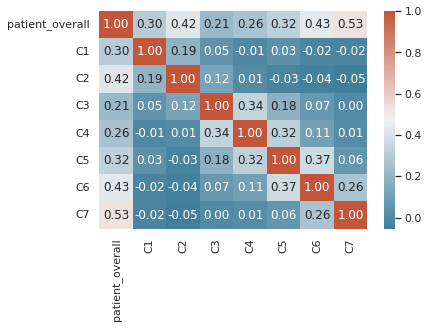

In [10]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(metadat.drop("slice_id", axis=1).corr(),annot=True, fmt = ".2f", cmap=cmap, linecolor='w')
plt.show()


We can see that C7 us highly correlated with the patient overall. This makes sense because it is the vertebra with the highest number of fractures from patient data. That means that if a patient has a fracture on C7 then they have a fracture overall. However, this is not new information. What is interesting is the correlation between C3 and C4, C4 and C5 and C5 and C6. There is a moderate level of correlation between these vertebra. This makes sense given how close they are to each other. If there is an injury in C3 there is likely to be an injury in C4. Interestingly, this moderate level of correlation is not observed with C1 and C2, C2 and C3 and C6 and C7 despite the vertebrae being close together. Again, this may be because of the curvature of the neck such that the middle vertebrae are harder to get fractured but when they do, they get fractured together. 

## Image Visualization
C1 - C5

In [11]:
def rand_verteb(path, number, random_state):
    '''Function to load the images and randomly select a given size of images
        path: which folder the images are in
        number: how many images to to select
        random_state: seed to make the results reproducible
    '''
    #set a seed
    np.random.seed(random_state)
    
    #read the files from the path and randomly select a given number
    files = os.scandir(path)
    files = [i.name for i in files]
    return np.random.choice(files, size=number, replace=False)

files = rand_verteb("/content/gdrive/MyDrive/Tutorial_Session/hadavands_minions/train_images/1.2.826.0.1.3680043.14", 400, 123) 

In [12]:
#code adopted from LBA assignment
def img_to_arr(imgs, path):
    #list to store images
    flattened = []
    
    # for each image combine the name with path 
    for img in imgs:
        # open it as a read file in binary mode
        with open(path+img, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                #cover = resizeimage.resize_cover(image, [512, 512])
                cover = image.resize((360,360))
                flattened.append((np.array(cover).flatten(), 0))
                
    # Flatten it once more
    flattened = np.asarray(flattened)
    
    return flattened

In [13]:
vertebs = img_to_arr(files, '/content/gdrive/MyDrive/Tutorial_Session/hadavands_minions/train_images/1.2.826.0.1.3680043.14/')

<ipython-input-12-1a89fcfb8a45>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flattened = np.asarray(flattened)


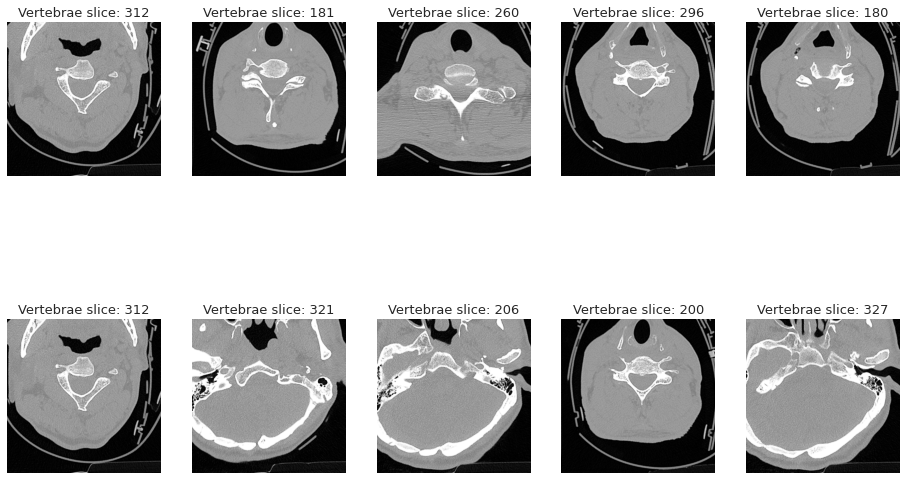

In [14]:
#display some of the images
# initializing the subplots
fig, axs = plt.subplots(2, 5, figsize=(16, 10))

#flatteen the axis
axs = axs.flatten()

# look at random selected vertebs
range_j = np.random.randint(0, len(vertebs), 10)
for p, ax in zip(range_j, axs):
    
    #resize the matrix to the same shape as the images and rotate
    ax.imshow(Image.fromarray(vertebs[p,0].reshape(360,360)), cmap='Greys_r')
    ax.set_title(f'Vertebrae slice: {p+1}', size=13)
    ax.axis('off')

The above shows different top view slices of the xrays

## EDA on Image Slices

In [15]:
base_folder: str = "/content/gdrive/MyDrive/Tutorial_Session/hadavands_minions"
segmentations_folder: str = base_folder + "/segmentations_npy/"

training_folder: str = base_folder + "/train_images/"


segmentations_df = pd.DataFrame({
    "segmentations": os.listdir(segmentations_folder)
})

segmentations_df["StudyInstanceUID"] = segmentations_df[
    "segmentations"
  ].str.strip(".npy")
segmentations_df["segmentations"] = segmentations_folder + segmentations_df[
    "segmentations"
  ]


segmentations_df = segmentations_df.set_index("StudyInstanceUID")

training_df = pd.DataFrame({
    "training": os.listdir(training_folder)
})

training_df["StudyInstanceUID"] = training_df["training"]

training_df["training"] = training_folder + training_df["training"]


training_df = training_df.set_index("StudyInstanceUID")

train_df = pd.read_csv(base_folder+"/train.csv")
train_df = train_df.set_index("StudyInstanceUID")

df = pd.concat([segmentations_df, training_df, train_df], axis=1)

df

segmentations  \
StudyInstanceUID                                                               
1.2.826.0.1.3680043.10633  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.10921  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.11827  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.11988  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.12281  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
...                                                                      ...   
1.2.826.0.1.3680043.23422                                                NaN   
1.2.826.0.1.3680043.30831                                                NaN   
1.2.826.0.1.3680043.501                                                  NaN   
1.2.826.0.1.3680043.30238                                                NaN   
1.2.826.0.1.3680043.6000                                                 NaN   

                                                                    training  \
StudyInstanceUID                                                               
1.2.826.0.1.3680043.10633  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.10921  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.11827  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.11988  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.12281  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
...                                                                      ...   
1.2.826.0.1.3680043.23422  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.30831  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.501    /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.30238  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.6000   /content/gdrive/MyDrive/Tutorial_Session/hadav...   

                           patient_overall   C1   C2   C3   C4   C5   C6   C7  
StudyInstanceUID                                                               
1.2.826.0.1.3680043.10633              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1.2.826.0.1.3680043.10921              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1.2.826.0.1.3680043.11827              1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
1.2.826.0.1.3680043.11988              1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  
1.2.826.0.1.3680043.12281              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...                                    ...  ...  ...  ...  ...  ...  ...  ...  
1.2.826.0.1.3680043.23422              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1.2.826.0.1.3680043.30831              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1.2.826.0.1.3680043.501                1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1.2.826.0.1.3680043.30238              1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  
1.2.826.0.1.3680043.6000               1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[2032 rows x 10 columns]

In [16]:
# !pip install matplotlib --upgrade

(0.0, 1300.0)

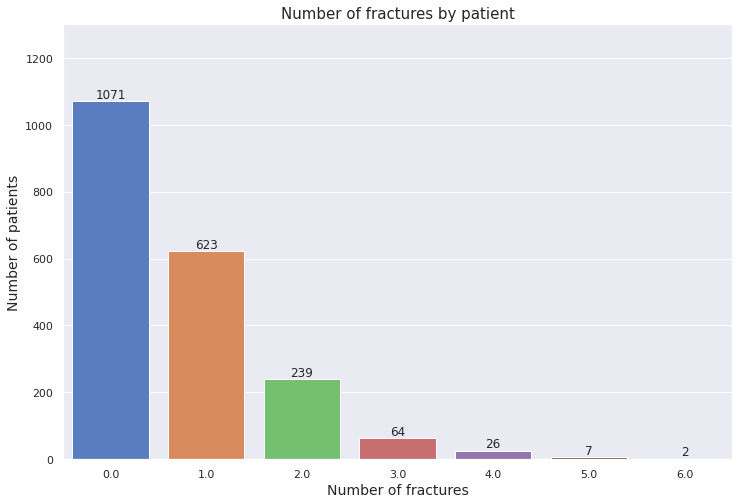

In [51]:
# distribution of fractures by patients
ig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x = df[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Number of fractures by patient', fontsize=15)
ax.set_xlabel('Number of fractures', fontsize=14)
ax.set_ylabel('Number of patients', fontsize=14)
plt.ylim([0,1300])

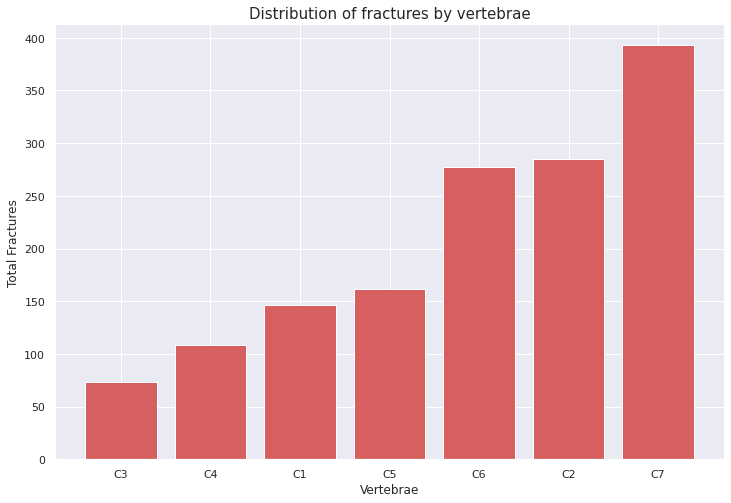

In [40]:
# Fracture total distribution for different vertebraes
fractures = df.loc[df["patient_overall"] == 1]
C1 = len(fractures.loc[fractures["C1"] == 1])
C2 = len(fractures.loc[fractures["C2"] == 1])
C3 = len(fractures.loc[fractures["C3"] == 1])
C4 = len(fractures.loc[fractures["C4"] == 1])
C5 = len(fractures.loc[fractures["C5"] == 1])
C6 = len(fractures.loc[fractures["C6"] == 1])
C7 = len(fractures.loc[fractures["C7"] == 1])
fractures_df = pd.DataFrame(dict(
    labels=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'],
    values=[C1, C2, C3, C4, C5, C6, C7]
))
fractures_df = fractures_df.sort_values('values')

fig, ax = plt.subplots(figsize=(12,8))
ax.bar('labels', 'values', data=fractures_df, color = 'r')
ax.set_title("Distribution of fractures by vertebrae", fontsize=15)
ax.set_xlabel("Vertebrae")
ax.set_ylabel("Total Fractures")
plt.show()

In [41]:
# Get the number of slices in each study
df["slices"] = df.training.apply(
    lambda path: len(os.listdir(path)))
df.head(3)

segmentations  \
StudyInstanceUID                                                               
1.2.826.0.1.3680043.10633  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.10921  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.11827  /content/gdrive/MyDrive/Tutorial_Session/hadav...   

                                                                    training  \
StudyInstanceUID                                                               
1.2.826.0.1.3680043.10633  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.10921  /content/gdrive/MyDrive/Tutorial_Session/hadav...   
1.2.826.0.1.3680043.11827  /content/gdrive/MyDrive/Tutorial_Session/hadav...   

                           patient_overall   C1   C2   C3   C4   C5   C6   C7  \
StudyInstanceUID                                                                
1.2.826.0.1.3680043.10633              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1.2.826.0.1.3680043.10921              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1.2.826.0.1.3680043.11827              1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

                           slices  
StudyInstanceUID                   
1.2.826.0.1.3680043.10633     429  
1.2.826.0.1.3680043.10921     339  
1.2.826.0.1.3680043.11827     208

Text(0.5, 0, 'Number of Slices')

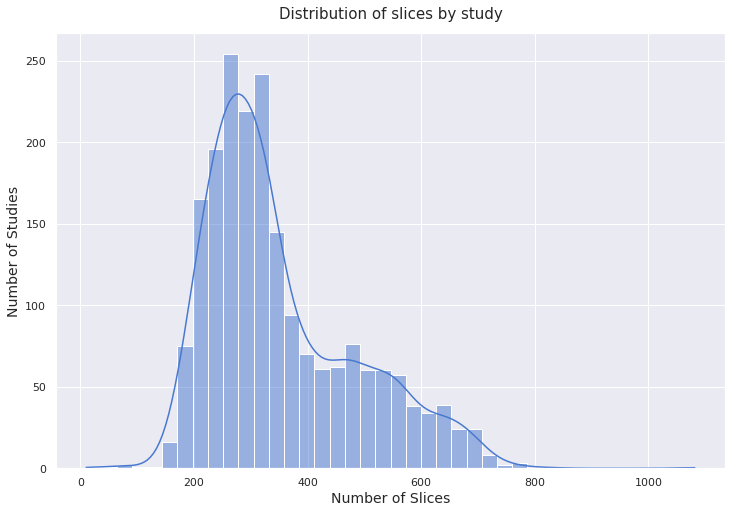

In [50]:
# Distribution of slices counts
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=df, x='slices', kde=True, bins=40, ax=ax)
ax.set_title("Distribution of slices by study", size=15, y=1.02)
ax.set_ylabel("Number of Studies", size=14)
ax.set_xlabel("Number of Slices", size = 14)

In [47]:
df['slices'].describe()

count    2032.000000
mean      352.296260
std       132.377092
min        10.000000
25%       257.000000
50%       314.000000
75%       429.000000
max      1082.000000
Name: slices, dtype: float64